# Análise de Séries Históricas de Tarifas Aéreas 

#### Frederico Horst

Fontes dos Dados:
- Séries históricas de tarifas aéreas, por origem, destino e empresa: disponível no site da ANAC em:
https://sistemas.anac.gov.br/sas/downloads/view/frmDownload.aspx
- Série histórica do IPCA: disponível no site do IBGE em:
https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=series-historicas

Mais informações sobre o tarifário:
https://www.anac.gov.br/assuntos/dados-e-estatisticas/mercado-do-transporte-aereo

Objetivo:
- Construir o intervalo de confiança da média de preços praticados por trecho. 
- O intervalo de confiança deve ser de 95% de confiança.
- O intervalo será por trecho, independente da companhia aérea. A ideia, primeiramente, é ver sob a ótica do consumidor.

Vamos começar rodando separadamente o arquivo main.py que executará as principais modificações nos arquivos. Neste notebook vamos apenas fazer a análise.

In [8]:
# importando libs necessárias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Importando as séries de dados resumidos e os dicionários:

In [32]:
df_tarifas_sts = pd.read_csv('df_tarifas_sts.csv')
df_tarifas_sts = df_tarifas_sts.drop(columns=['Unnamed: 0'])
df_tarifas_sts['PERIODO'] = df_tarifas_sts.PERIODO.astype(str)
# importando o dicionário de dados dos aeroportos:
aeroportos = pd.read_csv('aeroportos.csv',';')



In [10]:
# tarifas para entre as cidades: São Paulo, Brasília, Rio de Janeiro, Porto Alegre e Curitiba
cidades = ['São Paulo', 'Rio de Janeiro', 'Brasília', 'Porto Alegre', 'Curitiba']
aeroportos_selecionados = aeroportos[aeroportos['Cidade'].isin(cidades)]

In [11]:
origens = df_tarifas_sts['ORIGEM'].unique()
destinos = df_tarifas_sts['DESTINO'].unique()

In [36]:
df_tarifas_sts.columns.values

array(['ANO', 'MES', 'PERIODO', 'ORIGEM', 'DESTINO', 'TARIFA MÉDIA',
       'FREQUÊNCIA', 'TARIFA MÉDIA - PERCENTIL 2,5',
       'TARIFA MÉDIA - PERCENTIL 50', 'TARIFA MÉDIA - PERCENTIL 97,5'],
      dtype=object)

In [33]:
df_tarifas_sts.head()

,ANO,MES,PERIODO,ORIGEM,DESTINO,TARIFA MÉDIA,FREQUÊNCIA,"TARIFA MÉDIA - PERCENTIL 2,5",TARIFA MÉDIA - PERCENTIL 50,"TARIFA MÉDIA - PERCENTIL 97,5"
0,2002,1,200201,SBCT,SBRJ,290.026667,1350,282.501130,289.999259,296.805259
1,2002,2,200202,SBCT,SBRJ,259.495676,1850,252.134405,259.418649,265.495743
2,2002,3,200203,SBCT,SBRJ,257.126783,1893,251.672161,257.978605,262.082052
3,2002,4,200204,SBCT,SBRJ,254.194580,1439,247.901459,254.696664,261.284972
4,2002,5,200205,SBCT,SBRJ,266.096552,870,256.912816,267.023563,275.546437


### Gráficos:

SBCT SBRJ
SBRJ SBCT


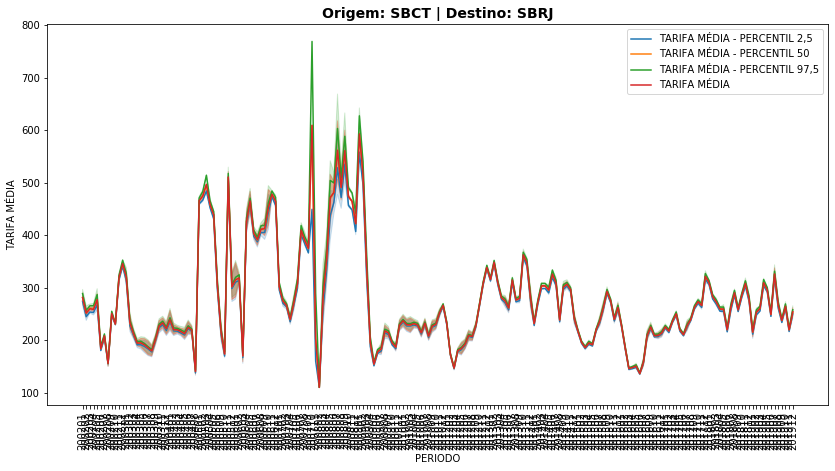

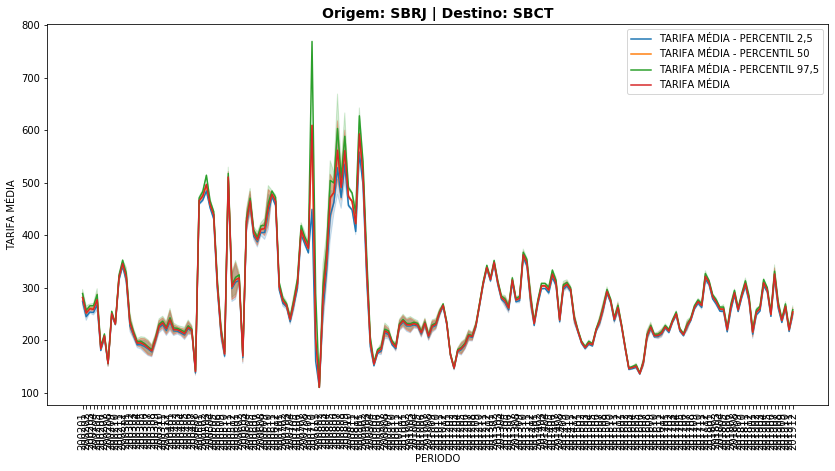

In [39]:
for origem in origens:
    for destino in destinos:
        if origem != destino:
            print(origem, destino)
            f, ax = plt.subplots(figsize=(14,7), sharey=True, sharex=True)
            f = sns.lineplot(x='PERIODO', y='TARIFA MÉDIA - PERCENTIL 2,5', data=df_tarifas_sts)
            f = sns.lineplot(x='PERIODO', y='TARIFA MÉDIA - PERCENTIL 50', data=df_tarifas_sts)
            f = sns.lineplot(x='PERIODO', y='TARIFA MÉDIA - PERCENTIL 97,5', data=df_tarifas_sts)
            f = sns.lineplot(x='PERIODO', y='TARIFA MÉDIA', data=df_tarifas_sts)
            f = ax.legend(['TARIFA MÉDIA - PERCENTIL 2,5','TARIFA MÉDIA - PERCENTIL 50', 'TARIFA MÉDIA - PERCENTIL 97,5', 'TARIFA MÉDIA'])
            f = ax.set_title('Origem: ' + str(origem) + ' | Destino: ' + str(destino), fontweight='bold',fontsize=14)
            f = ax.set_xlabel('PERIODO')
            f = plt.xticks(rotation=90)
        else:
            pass